In [16]:
from tqdm import tqdm
from keras_tqdm import TQDMNotebookCallback
from tqdm.keras import TqdmCallback
from libs.feature_extraction.vectorizers import BertVectorizer
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

test_index = "1"

In [25]:
train_df = pd.read_csv('./train-test-data/fold'+test_index+'/train_data.csv')
test_df = pd.read_csv('./train-test-data/fold'+test_index+'/test_data.csv')
train_df['vector'] = np.load('./train-test-data/fold'+test_index+'/train_vectors.npy').tolist()
test_df['vector'] = np.load('./train-test-data/fold'+test_index+'/test_vectors.npy').tolist()
train_data, val_data = train_test_split(train_df, test_size=0.25, random_state=42)
display(train_data.head())
x_train = np.array([np.array(xi) for xi in train_data['vector']])
y_train = to_categorical(pd.factorize(train_data['fastest'], sort=True)[0])
x_val = np.array([np.array(xi) for xi in val_data['vector']])
y_val = to_categorical(pd.factorize(val_data['fastest'], sort=True)[0])
x_test = np.array([np.array(xi) for xi in test_df['vector']])
y_test = to_categorical(pd.factorize(test_df['fastest'], sort=True)[0])
y_test_conf = pd.factorize(test_df['fastest'], sort=True)[0]

display(x_test[0:2])
display(y_test[0:10])
display(x_test.shape, y_test.shape)


,Unnamed: 0,index,code,comment,bert,bow,doc2vec,tfidf,word2vec,max,fastest,vector
29110,29110,36331,public Date getCreationDate() { return creatio...,Can you return creationDate.clone since Date i...,0.1010,0.1159,0.1307,0.3645,0.1846,tfidf,tfidf,"[0.6889752745628357, -0.2362436205148697, -0.2..."
56043,56043,69976,public CreateGlusterVolumeGeoRepSessionCommand...,for create session would geoRepSessionId exist...,0.2024,0.2528,0.2024,0.2607,0.2127,tfidf,tfidf,"[2.4171130657196045, 2.4713547229766846, 0.680..."
74506,74506,93054,synchronized void onSyncReply(final String ser...,How about to check whether workersToCheck is e...,0.1534,0.1625,0.1867,0.1779,0.1644,doc2vec,doc2vec,"[-2.2077674865722656, 1.886035442352295, -1.89..."
13896,13896,17264,public boolean equals(Object obj) { if (this =...,Better use instanceof comparison.,0.3437,0.1440,0.1844,0.1844,0.1830,bert,bert,"[0.5218641757965088, 0.25983256101608276, -1.3..."
91363,91363,114147,void onPlayPause() { if(controller == null) { ...,Init should only be called one single time whe...,0.1817,0.2545,0.2032,0.2545,0.1537,"bow,tfidf",tfidf,"[0.5635822415351868, 0.9144441485404968, 1.139..."


array([[ 1.90318477,  0.50331217, -0.3303802 , ...,  0.03001881,
        -1.80607843,  1.24600744],
       [ 0.25894779,  0.59880275,  0.15075082, ...,  2.13507771,
        -0.25691405, -0.49133706]])

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

(30136, 768)

(30136, 5)

In [26]:
inputs = Input((768,1))

x = Flatten()(inputs)
x = Dense(128, activation='relu')(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(5, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
callbacks = [  
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('check_point.h5', verbose=1, save_best_only=True, save_weights_only=True),
    TqdmCallback(verbose=2)
]
   
history = model.fit(x = x_train,
        y = y_train,
        validation_data = (x_val, y_val),
        epochs = 5,
        batch_size = 128,
        verbose = 0,
        callbacks=callbacks)

model.summary()

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/707 [00:00<?, ?batch/s]


Epoch 1: val_loss improved from inf to 1.57000, saving model to check_point.h5


  0%|          | 0.00/707 [00:00<?, ?batch/s]


Epoch 2: val_loss did not improve from 1.57000


  0%|          | 0.00/707 [00:00<?, ?batch/s]


Epoch 3: val_loss did not improve from 1.57000


  0%|          | 0.00/707 [00:00<?, ?batch/s]


Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 4: val_loss did not improve from 1.57000


  0%|          | 0.00/707 [00:00<?, ?batch/s]


Epoch 5: val_loss did not improve from 1.57000
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 768, 1)]          0         
                                                                 
 flatten_3 (Flatten)         (None, 768)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               98432     
                                                                 
 dense_10 (Dense)            (None, 128)               16512     
                                                                 
 dense_11 (Dense)            (None, 5)                 645       
                                                                 
Total params: 115,589
Trainable params: 115,589
Non-trainable params: 0
_________________________________________________________________


942/942 - 1s - loss: 1.6414 - accuracy: 0.2548 - 1s/epoch - 1ms/step
942/942 [==============================] - 1s 1ms/step

Testing Accuracy: 0.25484469532966614


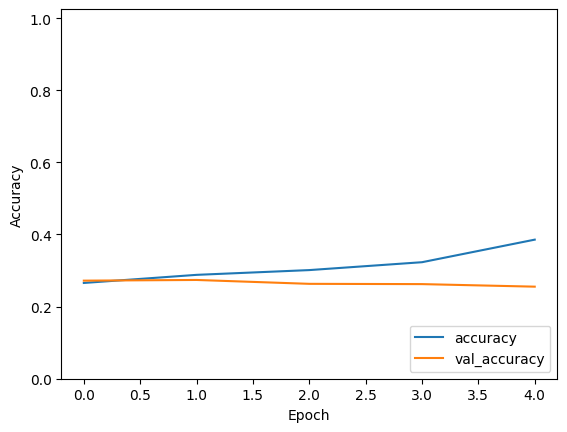

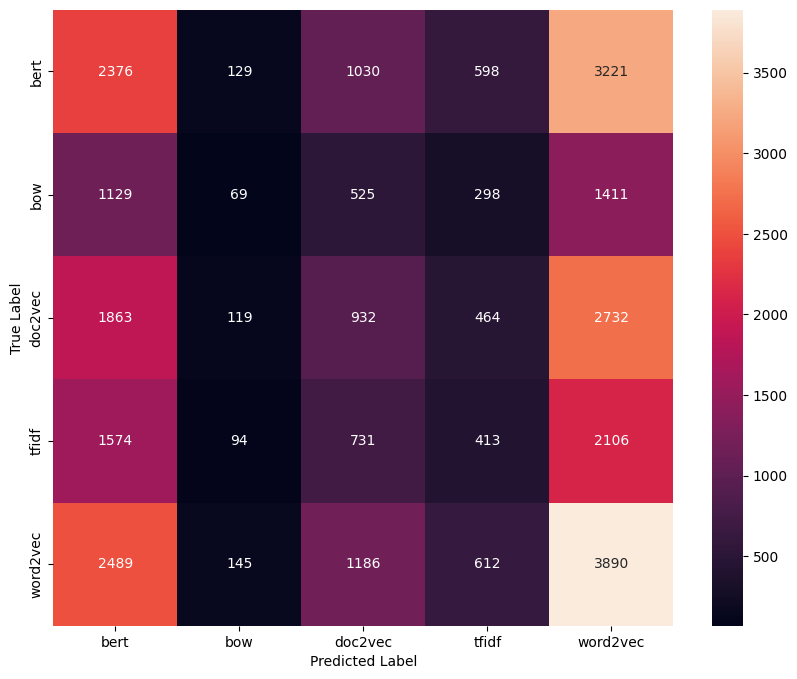

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot for Train and Validation Accuracy
def plot_train_val_acc(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1.025])
    plt.legend(loc='lower right')
    plt.show()

# Plotting Confusion Matrix
def plot_cnf_mtx(y_test, y_pred, filelabel):
    confusion_mtx = tf.math.confusion_matrix(y_test, y_pred) 
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_mtx, xticklabels = filelabel, yticklabels = filelabel, annot=True, fmt = 'g')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

 # Testing with Test Set
test_loss, test_acc = model.evaluate(x_test, y_test, verbose = 2)
y_pred = np.argmax(model.predict(x_test), axis = 1)
print("\nTesting Accuracy:", test_acc)

# Plotting Accuracy-Epoch Graph and Confusion Matrix
plot_train_val_acc(history)
labels = ['bert', 'bow', 'doc2vec', 'tfidf', 'word2vec']
plot_cnf_mtx(y_test_conf, y_pred, labels)